# Unsupervised anomaly detection (fraud) algorithm

In [3]:
from datetime import datetime
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline
start_time = datetime.now()

In [4]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 1.18 s, sys: 173 ms, total: 1.36 s
Wall time: 1.38 s


(1070994, 32)

In [5]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [6]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some properties that we aren't interested in

In [8]:
numrecords_orig = len(data)
numrecords = numrecords_orig
numrecords

1070994

In [9]:
#remove the records with easement type as goverment 
data = data[data["EASEMENT"] != "U"].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 1


In [10]:
# create some words for the owner name that might be goverment or a cemetery
gov_list = ['DEPT ', 'DEPARTMENT', 'UNITED STATES','GOVERNMENT',' GOVT ', 'CEMETERY']

# owner = list(set(data['OWNER'].to_list()))
# owner.pop(0) #remove the nan

owner1 = list(set(data['OWNER'].to_list()))
owner = [item for item in owner1 if str(item) != 'nan'] # remove any nan's

remove_list = []
print("Total owner number before removing is ", len(owner))

for i in owner:
   for g in gov_list:
    if g in i and 'STORES' not in i:
        remove_list.append(i)

Total owner number before removing is  863347


In [11]:
remove_list # check all the name here and edit if it is not a goverment name 

['U S GOVERNMENT',
 'GOVERNMENT/THE ETC',
 'NYC DEPT OF W S G E',
 'THE WOODLAWN CEMETERY',
 'UNITED STATES POSTALS',
 'DEPT OF R E IN-REM',
 'LIBERTY DEPARTMENT ST',
 'NYC DEPT HWAY',
 'U S GOVT POST OFFIC',
 'NYC DEPT WATER RESOUR',
 'MOUNT CARMEL CEMETERY',
 'NYC DEPT OF WATER RES',
 'NYC DEPT PUBLIC WORKS',
 'NY STATE DEPT TRANSP',
 'NYC DEPT HIGHWAYS',
 'DEPARTMENT OF CULTURA',
 'UNITED STATES A VA',
 'STATE OF N Y DEPT TRA',
 'DEPT OF HIGHWAYS NYC',
 'NYS DEPT OF ENV. CONS',
 'NYC DEPARTMENT OF FIN',
 'GOVERNMENT OF BARBADO',
 'GOVERNMENT FED REP BR',
 'NYCITY - DEPT OF HWAY',
 'UNITED STATES POSTAL',
 'ST MARYS CEMETERY',
 'UNITED STATES A-V A',
 'THE GOVERNMENT OF MON',
 'GOVERNMENT MALAYSIA',
 'THE GOVERNMENT OF THE',
 'CITY OF NY-DEPT HWY',
 'MT CARMEL CEMETERY',
 'GREEN-WOOD CEMETERYIN',
 'U S GOVT COAST GUARD',
 'GOVERNMENT OF MALAYSI',
 'WASHINGTON CEMETERY C',
 'GOVERNMENT REPUBLICTO',
 'NYC DEPT HGHWAYS',
 'THE UNITED STATES POS',
 'NYC DEPT PUBLIC WKS',
 'DEPT OF HWAYS'

In [12]:
# Look at the most frequent owners. This might show some other properties we aren't interested in.
remove_list2 = data['OWNER'].value_counts().head(20).index.tolist()
remove_list2

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [13]:
# add some others to also be removed
remove_list2.append('THE CITY OF NEW YORK')
remove_list2.append('NYS URBAN DEVELOPMENT')
remove_list2.append('CULTURAL AFFAIRS')
remove_list2.append('NY STATE PUBLIC WORKS')
remove_list2.append("NYC DEP'T OF HIGHWAYS")
remove_list2.append('CITY WIDE ADMINISTRAT')
remove_list2.append('NEW YORK CITY')
remove_list2.append('THE PORT OFNY & NJ')
remove_list2.append('NEW YORK STATE DEPART')
remove_list2.append('CITY AND NON-CITY OWN')
remove_list2.append('SANITATION')
remove_list2.append('NYS DOT')
remove_list2.append('NEW YORK CITY TRANSIT')
remove_list2.append('PORT AUTHORITY OF NY')
remove_list2.append('NEW YORK STATE OWNED')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('PORT OF NEW YORK AUTH')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('LIRR')
remove_list2.append('NY STATE PUBLIC SERV')
remove_list2.append('STATE OF NEW YORK')
remove_list2.append('NYC HIGHWAY DEPT')
remove_list2.append('CITY OF NY/PARKS AND')

In [14]:
for i in remove_list2:
    if i not in remove_list:
        remove_list.append(i)
    else:
        print(i)

DEPT OF ENVIRONMENTAL
DEPARTMENT OF BUSINES
DEPT OF TRANSPORTATIO
NYC PARK DEPT


In [15]:
# delete some of the removes...
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.remove('MH RESIDENTIAL 1, LLC')

In [16]:
len(remove_list)

264

In [17]:
numrecords = len(data)
removed = data[data['OWNER'].isin(remove_list)].reset_index(drop=True)
data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 26501


In [18]:
removed.shape

(26501, 32)

In [19]:
# any on this list that we shouldn't remove? If so, go back and remove them from the remove list.
# plt.rcParams.update({'figure.figsize':(6,14)})
plt.figure(figsize=(6,14))
plt.xscale('log')
removed['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

<Axes: ylabel='OWNER'>

In [20]:
data.shape

(1044492, 32)

In [21]:
# this is how many records we removed
numrecords_orig - len(data)

26502

In [22]:
data.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
5,14,1000041006,1,4,1006,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,353383.0,1138493.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
6,15,1000041007,1,4,1007,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1246572.0,4016063.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
7,16,1000041008,1,4,1008,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
8,17,1000041009,1,4,1009,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
9,18,1000041010,1,4,1010,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## Fill in missing ZIP

In [24]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
num_missing_zips_orig = len(missing_zips)
num_missing_zips_orig

20431

In [25]:
sum(data['BORO'].isna())

0

In [26]:
sum(data['STADDR'].isna())

364

In [27]:
# concatenate the 'staddr' and 'boro' columns into a new 'staddr_boro' column 
data['staddr_boro'] = data[data['STADDR'].notnull()]['STADDR'] + '_' + data[data['BORO'].notnull()]['BORO'].astype(str)
data['staddr_boro']

0              1 WATER STREET_1
1              1 WATER STREET_1
2              1 WATER STREET_1
3              1 WATER STREET_1
4              1 WATER STREET_1
                   ...         
1044487    142 BENTLEY STREET_5
1044488    146 BENTLEY STREET_5
1044489    150 BENTLEY STREET_5
1044490    156 BENTLEY STREET_5
1044491    162 BENTLEY STREET_5
Name: staddr_boro, Length: 1044492, dtype: object

In [28]:
staddr_boro_zip = {}
for index, staddrboro in data['staddr_boro'].items():
    if staddrboro not in staddr_boro_zip :
        staddr_boro_zip [staddrboro] = data.loc[index, 'ZIP']
        
        
# fill in by mapping with street addrees boroughs
data['ZIP'] = data['ZIP'].fillna(data['staddr_boro'].map(staddr_boro_zip))

In [29]:
# how many missing zips did we fill in with this last step?
num_filled_in = num_missing_zips_orig - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

2832

In [30]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

17599

In [31]:
%%time
# Assume data is sorted by zip. Fill in a missing zip if the previous and next record have the same zip
zip_forward_filled = data['ZIP'].fillna(method='ffill')
zip_backward_filled = data['ZIP'].fillna(method='bfill')
data['ZIP'] = data['ZIP'].mask((zip_forward_filled == zip_backward_filled) & data['ZIP'].isna(),zip_forward_filled)

CPU times: user 7.2 ms, sys: 6.01 ms, total: 13.2 ms
Wall time: 8.85 ms


<timed exec>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<timed exec>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [32]:
# how many missing zips did we fill in with this last step?
num_filled_in = len(missing_zips) - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

16126

In [33]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

1473

In [34]:
%time
data['ZIP'].fillna(method='ffill', inplace=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.91 μs


/var/folders/b3/cdbzzh312v7cg__qxz52ps_00000gn/T/ipykernel_1464/2418375584.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ZIP'].fillna(method='ffill', inplace=True)
/var/folders/b3/cdbzzh312v7cg__qxz52ps_00000gn/T/ipykernel_1464/2418375584.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['ZIP'].fillna(method='ffill', inplace=True)


In [35]:
# For the remaining missing zips, just fill in with the previous record's zip.
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

0

In [36]:
data = data.drop('staddr_boro', axis=1)

### FULLVAL, AVLAND, AVTOT

#### FULLVAL

In [39]:
len(data[data['FULLVAL']==0])

10025

In [40]:
data['FULLVAL'].isnull().sum()

0

In [41]:
data['FULLVAL'].replace(0, np.nan, inplace=True)
data['FULLVAL'].isnull().sum()

/var/folders/b3/cdbzzh312v7cg__qxz52ps_00000gn/T/ipykernel_1464/3840300546.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['FULLVAL'].replace(0, np.nan, inplace=True)


10025

In [42]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

7307

In [43]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

386

In [44]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

0

#### AVLAND

In [46]:
len(data[data['AVLAND']==0])

10027

In [47]:
data['AVLAND'].isnull().sum()

0

In [48]:
data['AVLAND'].replace(0, np.nan, inplace=True)
data['AVLAND'].isnull().sum()

/var/folders/b3/cdbzzh312v7cg__qxz52ps_00000gn/T/ipykernel_1464/116382313.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['AVLAND'].replace(0, np.nan, inplace=True)


10027

In [49]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

7307

In [50]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

386

In [51]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

0

#### AVTOT

In [53]:
len(data[data['AVTOT']==0])

10025

In [54]:
data['AVTOT'].isnull().sum()

0

In [55]:
data['AVTOT'].replace(0, np.nan, inplace=True)
data['AVTOT'].isnull().sum()

/var/folders/b3/cdbzzh312v7cg__qxz52ps_00000gn/T/ipykernel_1464/3655551349.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['AVTOT'].replace(0, np.nan, inplace=True)


10025

In [56]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

7307

In [57]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

386

In [58]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

0

In [59]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in the missing STORIES

In [61]:
data['STORIES'].isnull().sum()

42029

In [62]:
modes = data.groupby(['BORO', 'BLDGCL'])['STORIES'] \
         .transform(lambda x: x.mode(dropna=False).iloc[0])
data['STORIES'] = data['STORIES'].fillna(modes)

In [63]:
data['STORIES'].isnull().sum()

37921

In [64]:
data["STORIES"] = data.\
                        groupby(['TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))

In [65]:
data['STORIES'].isnull().sum()

0

In [66]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [68]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them with NA.
# Probably OK for BLD dimensions to be zero. Property could have no building.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
# Not sure which values to treat as missing. Here are some choices.
data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
# data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
# data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [69]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


#### LTFRONT

In [71]:
data['LTFRONT'].isnull().sum()

161133

In [72]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data[data['LTFRONT'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [73]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data['LTFRONT'].isnull().sum()

0

#### LTDEPTH

In [75]:
data['LTDEPTH'].isnull().sum()

161715

In [76]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data[data['LTDEPTH'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,45.465048,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,45.465048,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [77]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['LTDEPTH'].isnull().sum()

0

#### BLDFRONT

In [79]:
data['BLDFRONT'].isnull().sum()

75

In [80]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [81]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [82]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

#### BLDEPTH

In [84]:
data['BLDDEPTH'].isnull().sum()

58

In [85]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [86]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [87]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [88]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [89]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [90]:
data.count()

RECORD      1044492
BBLE        1044492
BORO        1044492
BLOCK       1044492
LOT         1044492
EASEMENT       1976
OWNER       1012748
BLDGCL      1044492
TAXCLASS    1044492
LTFRONT     1044492
LTDEPTH     1044492
EXT          353646
STORIES     1044492
FULLVAL     1044492
AVLAND      1044492
AVTOT       1044492
EXLAND      1044492
EXTOT       1044492
EXCD1        623528
STADDR      1044128
ZIP         1044492
EXMPTCL        9295
BLDFRONT    1044492
BLDDEPTH    1044492
AVLAND2      266065
AVTOT2       266071
EXLAND2       80844
EXTOT2       117833
EXCD2         92904
PERIOD      1044492
YEAR        1044492
VALTYPE     1044492
zip3        1044492
dtype: int64

In [91]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [93]:
# epsilon is an arbitrary small number to make sure we don't divide by zero
epsilon = .0001
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH'] + epsilon
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH'] + epsilon
data['bldvol'] = data['bldsize'] * data['STORIES'] + epsilon

In [94]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [95]:
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,...,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,5.368071e+05,3.220281e+00,4.756780e+03,3.509016e+02,5.045399e+01,1.073810e+02,4.969850e+00,8.163420e+05,6.643735e+04,1.998216e+05,...,1.882881e+04,2.107176e+02,8.691048e+08,1.025811e+08,9.964520e+00,1.229273e+08,1.614537e+07,2.534231e+01,3.768438e+08,4.167343e+07
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267098e+02,5.999403e+01,5.153434e+01,8.225043e+00,6.394366e+06,2.009129e+06,5.391132e+06,...,2.320270e+06,4.571328e+02,2.914578e+10,3.376951e+09,6.514882e+01,1.792873e+10,4.400470e+09,1.593315e+02,4.746549e+10,1.150766e+10
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,3.614764e-04,4.167249e-03,1.344274e-04,8.333333e-06,3.217901e-04,1.038033e-05,8.333333e-06,1.875268e-03,6.049251e-05
25%,2.729098e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.890002e+02,7.566667e+01,4.586805e+02,2.176470e+02,2.370748e+00,1.355000e+01,6.486902e+00,5.378464e+00,2.450623e+01,1.168055e+01
50%,5.387725e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548800e+03,1.533719e+02,6.365131e+02,3.102940e+02,4.590250e+00,1.884557e+01,9.274471e+00,8.619412e+00,3.302222e+01,1.613286e+01
75%,8.022752e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120598e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,2.430000e+02,1.073529e+03,5.109755e+02,7.215789e+00,3.453179e+01,1.704545e+01,1.352433e+01,1.077928e+02,4.291773e+01
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,8.586666e+04,1.663775e+13,2.376821e+12,3.728371e+04,1.792809e+13,4.482022e+12,3.864000e+04,4.668309e+13,1.167077e+13


I want outliers in these 9 variables, either very high or very low. Very high is easy to find but very low might be close to
zero and probably not many standard deviations below the average. A simple way to look for outliers that are very low is to also include 1/over these variables, which will be very large outliers when the variables are very low.
First I scale them all to have reasonable average.

In [97]:
vars9 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
for vars in vars9:
    data[vars] = data[vars]/data[vars].median()
    
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,...,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,5.368071e+05,3.220281e+00,4.756780e+03,3.509016e+02,5.045399e+01,1.073810e+02,4.969850e+00,8.163420e+05,6.643735e+04,1.998216e+05,...,1.882881e+04,1.373900e+00,1.365416e+06,3.305932e+05,2.170801e+00,6.522877e+06,1.740841e+06,2.940143e+00,1.141183e+07,2.583140e+06
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267098e+02,5.999403e+01,5.153434e+01,8.225043e+00,6.394366e+06,2.009129e+06,5.391132e+06,...,2.320270e+06,2.980552e+00,4.578976e+07,1.088307e+07,1.419287e+01,9.513500e+08,4.744712e+08,1.848519e+01,1.437380e+09,7.133054e+08
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,2.356863e-06,6.546997e-06,4.332258e-07,1.815442e-06,1.707511e-05,1.119236e-06,9.668100e-07,5.678806e-05,3.749645e-06
25%,2.729098e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.890002e+02,4.933542e-01,7.206144e-01,7.014218e-01,5.164747e-01,7.190018e-01,6.994363e-01,6.239943e-01,7.421134e-01,7.240224e-01
50%,5.387725e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548800e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,8.022752e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120598e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,1.584384e+00,1.686579e+00,1.646746e+00,1.571982e+00,1.832356e+00,1.837889e+00,1.569055e+00,3.264251e+00,2.660268e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,5.598592e+02,2.613890e+10,7.659900e+09,8.122370e+03,9.513159e+11,4.832645e+11,4.482904e+03,1.413687e+12,7.234161e+11


In [98]:
# add in the inverse of all the 9 primary variables.
for vars in vars9:
    data[vars+'inv'] = 1/(data[vars] + epsilon)

In [99]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv,r9inv
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,2.157505e+07,0.319454,1.613565e-08,4.011648e-07,0.059294,2.962707e-09,7.435988e-08,0.039897,1.860257e-09,4.634984e-08
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,3.118004e+07,0.221048,1.116507e-08,2.775862e-07,0.041028,2.050045e-09,5.145332e-08,0.027607,1.287206e-09,3.207180e-08
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,5.797447e+07,0.118886,6.004840e-09,1.492924e-07,0.038983,1.947862e-09,4.888868e-08,0.014848,6.922897e-10,1.724897e-08
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,5.534532e+06,1.245200,6.290102e-08,1.563846e-06,0.231138,1.154937e-08,2.898734e-07,0.155527,7.251765e-09,1.806837e-07
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,1.267796e+07,0.543627,2.745927e-08,6.826928e-07,0.100904,5.041848e-09,1.265435e-07,0.067895,3.165740e-09,7.887705e-08


Now I want the large outliers where the variables are either very low or very high, so I'll keep only one of the two, r or rinv, depending on which is largest. This allows me to find both the very low and high outliers.

In [101]:
for vars in vars9:
    data[vars] = data[[vars,vars+'inv']].max(axis=1)

Now I can remove the inverse columns since I have the 9 variables that I need

In [103]:
for vars in vars9:
    data.drop(columns=(vars+'inv'),inplace=True)

data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,...,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,5.368071e+05,3.220281e+00,4.756780e+03,3.509016e+02,5.045399e+01,1.073810e+02,4.969850e+00,8.163420e+05,6.643735e+04,1.998216e+05,...,1.882881e+04,1.294407e+01,1.365419e+06,3.306131e+05,8.518748e+00,6.522880e+06,1.740853e+06,5.746087e+00,1.141183e+07,2.583144e+06
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267098e+02,5.999403e+01,5.153434e+01,8.225043e+00,6.394366e+06,2.009129e+06,5.391132e+06,...,2.320270e+06,1.088700e+02,4.578976e+07,1.088307e+07,7.580206e+01,9.513500e+08,4.744712e+08,5.249257e+01,1.437380e+09,7.133054e+08
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,9.999570e-01,9.999527e-01,9.999526e-01,9.999539e-01,9.999542e-01,9.999570e-01,9.999514e-01,9.999505e-01,9.999505e-01
25%,2.729098e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.890002e+02,1.269474e+00,1.175687e+00,1.193296e+00,1.262922e+00,1.164241e+00,1.190033e+00,1.233189e+00,1.167393e+00,1.193659e+00
50%,5.387725e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548800e+03,1.701746e+00,1.463995e+00,1.492702e+00,1.682360e+00,1.461362e+00,1.524923e+00,1.585997e+00,1.468319e+00,1.502809e+00
75%,8.022752e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120598e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,3.207889e+00,5.341069e+00,5.831286e+00,3.260424e+00,7.953975e+00,9.407930e+00,2.710417e+00,4.898251e+00,4.631073e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,9.769741e+03,2.613890e+10,7.659900e+09,9.821693e+03,9.513159e+11,4.832645e+11,9.904245e+03,1.413687e+12,7.234161e+11


Now I add more variables where I standardize each of these 9 basic variables by a few logical groupings.
For example, is a property's value of r1 typical for that zip code? for that taxclass?

In [105]:
# Standardized variables by appropriate logical group
zip5_mean = data.groupby('ZIP')[vars9].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars9].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars9:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [106]:
# include two more possibly interesting variables
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
# again, use 1/variable if that's larger, in order to find the low outliers
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])
data['size_ratio'] = data['bldsize'] / (data['ltsize']+1)

In [107]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
...,...,...,...,...,...
r7_taxclass,1.288211,1.86171,3.461563,0.330458,0.756981
r8_taxclass,7.20413,10.411337,19.358271,1.848037,4.233301
r9_taxclass,1.127871,1.629988,3.03071,0.289327,0.662761
value_ratio,8.056712,8.056715,7.13503,8.056724,8.05672


In [108]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass',
       'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass',
       'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'value_ratio',
       'size_ratio'],
      dtype='object')

In [109]:
save_record = data['RECORD']
save_record.head()

0     9
1    10
2    11
3    12
4    13
Name: RECORD, dtype: int64

In [110]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1044492, 29)

In [111]:
# this dataframe is now just the variables for our unsupervised fraud models
data.head().transpose()

,0,1,2,3,4
r1,3.130243e+00,4.523796e+00,8.411301e+00,1.245200e+00,1.839398e+00
r2,6.197457e+07,8.956501e+07,1.665323e+08,1.589799e+07,3.641757e+07
r3,2.492741e+06,3.602484e+06,6.698264e+06,6.394491e+05,1.464788e+06
r4,1.686504e+01,2.437321e+01,2.565179e+01,4.326310e+00,9.910288e+00
r5,3.375292e+08,4.877942e+08,5.133833e+08,8.658481e+07,1.983400e+08
r6,1.344811e+07,1.943509e+07,2.045463e+07,3.449782e+06,7.902422e+06
r7,2.506448e+01,3.622294e+01,6.735096e+01,6.429659e+00,1.472843e+01
r8,5.375602e+08,7.768767e+08,1.444482e+09,1.378975e+08,3.158819e+08
r9,2.157505e+07,3.118004e+07,5.797447e+07,5.534532e+06,1.267796e+07
r1_zip5,3.448109e-01,4.983172e-01,9.265440e-01,1.371645e-01,2.026182e-01


In [112]:
# Calculate and write the basic statistics of all the variables to check if everything looks OK
stats = data.describe().transpose()
# stats.to_excel('stats_on_vars.xlsx')
stats

,count,mean,std,min,25%,50%,75%,max
r1,1044492.0,1.294407e+01,1.088700e+02,9.999570e-01,1.269474e+00,1.701746,3.207889,9.769741e+03
r2,1044492.0,1.365419e+06,4.578976e+07,9.999527e-01,1.175687e+00,1.463995,5.341069,2.613890e+10
r3,1044492.0,3.306131e+05,1.088307e+07,9.999526e-01,1.193296e+00,1.492702,5.831286,7.659900e+09
r4,1044492.0,8.518748e+00,7.580206e+01,9.999539e-01,1.262922e+00,1.682360,3.260424,9.821693e+03
r5,1044492.0,6.522880e+06,9.513500e+08,9.999542e-01,1.164241e+00,1.461362,7.953975,9.513159e+11
r6,1044492.0,1.740853e+06,4.744712e+08,9.999570e-01,1.190033e+00,1.524923,9.407930,4.832645e+11
r7,1044492.0,5.746087e+00,5.249257e+01,9.999514e-01,1.233189e+00,1.585997,2.710417,9.904245e+03
r8,1044492.0,1.141183e+07,1.437380e+09,9.999505e-01,1.167393e+00,1.468319,4.898251,1.413687e+12
r9,1044492.0,2.583144e+06,7.133054e+08,9.999505e-01,1.193659e+00,1.502809,4.631073,7.234161e+11
r1_zip5,1044492.0,1.000000e+00,8.217454e+00,5.039810e-03,1.620008e-01,0.321577,0.664211,2.284920e+03


In [113]:
# data.to_csv('NY vars.csv', index=False)

In [114]:
data.isna().sum().sum()

0

In [115]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1044492.0,3.823151e-17,1.0,-0.109710,-0.107234,-0.103264,-0.089429,89.618766
r2,1044492.0,3.983696e-17,1.0,-0.029819,-0.029819,-0.029819,-0.029819,570.816079
r3,1044492.0,1.655111e-17,1.0,-0.030379,-0.030379,-0.030379,-0.030378,703.806269
r4,1044492.0,6.536091e-17,1.0,-0.099190,-0.095721,-0.090187,-0.069369,129.457889
r5,1044492.0,-8.520456e-19,1.0,-0.006856,-0.006856,-0.006856,-0.006856,999.957285
r6,1044492.0,-1.090992e-18,1.0,-0.003669,-0.003669,-0.003669,-0.003669,1018.529092
r7,1044492.0,7.278952e-17,1.0,-0.090415,-0.085972,-0.079251,-0.057830,188.569522
r8,1044492.0,-6.017040e-18,1.0,-0.007939,-0.007939,-0.007939,-0.007939,983.508585
r9,1044492.0,1.787425e-18,1.0,-0.003621,-0.003621,-0.003621,-0.003621,1014.170858
r1_zip5,1044492.0,-2.680287e-17,1.0,-0.121079,-0.101978,-0.082559,-0.040863,277.935175


In [116]:
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

In [117]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

(0.0, 1.0)

In [118]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 1.82 s, sys: 195 ms, total: 2.01 s
Wall time: 689 ms


5

In [119]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.27908514 0.4667656  0.61435657 0.7090587  0.7562435 ]


In [120]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1044492, 5)

In [121]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.625151,0.037534,-0.077495,0.126964,0.863770
1,0.962183,0.258705,-0.119726,0.163168,1.152296
2,1.667141,0.690240,-0.258814,0.152342,2.000525
3,0.062475,-0.328045,-0.006789,0.066493,0.381345
4,0.312960,-0.167336,-0.038376,0.093430,0.596509


In [122]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,3.017704e-17,3.191855e-17,2.620423e-17,1.603410e-17,5.904795e-18
std,2.844902e+00,2.332967e+00,2.068849e+00,1.657215e+00,1.169769e+00
min,-5.015535e-01,-1.225369e+02,-9.392000e+02,-5.798701e+02,-2.231438e+02
25%,-1.243610e-01,-2.692587e-01,3.125217e-02,4.618834e-02,-8.575840e-02
50%,-1.199425e-01,-2.119116e-01,3.765687e-02,5.218774e-02,-4.856385e-02
75%,-9.894908e-02,-1.209430e-01,4.136593e-02,5.267692e-02,1.064451e-01
max,2.078522e+03,4.562133e+02,6.098382e+02,1.101210e+03,4.471563e+02


# zscale the pcs.


In [125]:
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,-3.537435e-19,-1.006808e-17,7.891200e-19,1.346946e-18,1.137421e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.762990e-01,-5.252409e+01,-4.539721e+02,-3.499064e+02,-1.907589e+02
25%,-4.371363e-02,-1.154147e-01,1.510606e-02,2.787106e-02,-7.331226e-02
50%,-4.216051e-02,-9.083353e-02,1.820184e-02,3.149123e-02,-4.151577e-02
75%,-3.478119e-02,-5.184085e-02,1.999466e-02,3.178641e-02,9.099668e-02
max,7.306128e+02,1.955507e+02,2.947717e+02,6.644945e+02,3.822603e+02


In [126]:
data_pca_zs.shape

(1044492, 5)

In [127]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.219744,0.016089,-0.037458,0.076613,0.738411
1,0.338213,0.110891,-0.057871,0.098459,0.985063
2,0.586010,0.295864,-0.125100,0.091926,1.710188
3,0.021960,-0.140613,-0.003281,0.040123,0.326000
4,0.110007,-0.071727,-0.018550,0.056378,0.509937


## Now calculate two unsupervised fraud scores

In [129]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Reasonable choices are anywhere from 1 to about 4.
# The higher the power the more the distance measure focuses on the large dimensional displacements.
p1 = 2
p2 = 2
ntop = 10000

### Calculate score 1

In [131]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0    0.775287
1    1.053602
2    1.838420
3    0.357982
4    0.529910
5    0.511855
6    1.381865
7    1.348378
8    1.348378
9    1.348378
dtype: float64

In [132]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,0.219744,0.016089,-0.037458,0.076613,0.738411
1,0.338213,0.110891,-0.057871,0.098459,0.985063
2,0.586010,0.295864,-0.125100,0.091926,1.710188
3,0.021960,-0.140613,-0.003281,0.040123,0.326000
4,0.110007,-0.071727,-0.018550,0.056378,0.509937
5,0.101474,-0.078555,-0.017079,0.054804,0.492171
6,0.475136,0.220461,-0.081463,0.123708,1.270139
7,0.461246,0.209346,-0.079070,0.121146,1.241218
8,0.461246,0.209346,-0.079070,0.121146,1.241218
9,0.461246,0.209346,-0.079070,0.121146,1.241218


In [133]:
score1.max()

1006.4007283461684

### Autoencoder for score 2

In [135]:
%%time
# you don't need the autoencoder to be really good, just a little bit trained so it can find the really unusual records
# you can set max_iter to 100 and it takes about a minute, or 500 and it takes about 7 minutes. But even 50 is good enough.
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=100,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 34.1 s, sys: 137 ms, total: 34.3 s
Wall time: 34.5 s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=100,
             random_state=1)

In [136]:
# calculate score 2 as the error of an autoencoder
# Again we'll use Minkowski distance for the error (difference betwen the input and output vectors)
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [137]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,0.775287,0.437821,9
1,1.053602,0.596822,10
2,1.838420,1.008619,11
3,0.357982,0.177411,12
4,0.529910,0.291332,13
5,0.511855,0.280063,14
6,1.381865,0.779979,15
7,1.348378,0.761448,16
8,1.348378,0.761448,17
9,1.348378,0.761448,18


In [138]:
# do a rank-order scaling. Replace the score with the sorted rank order
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,0.775287,0.437821,9,1004949.0,1020584.0
1,1.053602,0.596822,10,1015068.0,1028224.0
2,1.838420,1.008619,11,1028447.0,1035697.0
3,0.357982,0.177411,12,956629.0,972735.0
4,0.529910,0.291332,13,987777.0,1007499.0
5,0.511855,0.280063,14,985854.0,1005700.0
6,1.381865,0.779979,15,1022390.0,1032331.0
7,1.348378,0.761448,16,1021858.0,1031988.0
8,1.348378,0.761448,17,1021857.0,1031989.0
9,1.348378,0.761448,18,1021856.0,1031987.0


In [139]:
# calculate the final score as the average of the two scores
# you could do other possible combinations of these if you want
# You could do different weightings, or a max or min
weight = .5
scores['final'] = (weight*scores['score1 rank'] + (1-weight)*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores_sorted.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
897397,1006.400728,1006.394786,917942,1044492.0,1044492.0,1044492.0
544655,639.468504,590.165016,561383,1044491.0,1044491.0,1044491.0
1028917,485.727334,461.219565,1053832,1044490.0,1044490.0,1044490.0
148176,417.114776,379.577942,151044,1044489.0,1044489.0,1044489.0
383033,384.202091,358.362749,398266,1044488.0,1044488.0,1044488.0
676142,321.959426,297.092811,694272,1044487.0,1044487.0,1044487.0
383044,293.476973,268.406326,398284,1044486.0,1044486.0,1044486.0
29547,275.488029,251.679792,30042,1044484.0,1044485.0,1044484.5
230836,282.996129,233.051469,241946,1044485.0,1044484.0,1044484.5
960229,260.369666,202.407650,982930,1044483.0,1044482.0,1044482.5


In [140]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
560994,0.013322,0.008939,577845,32.0,232.0,132.0
561945,0.027238,0.006968,578815,191.0,65.0,128.0
933562,0.027057,0.006388,955576,190.0,60.0,125.0
283239,0.023358,0.007654,295182,112.0,107.0,109.5
561770,0.014443,0.008059,578637,40.5,149.5,95.0
561767,0.014443,0.008059,578634,40.5,149.5,95.0
561799,0.015149,0.007407,578666,48.0,98.0,73.0
561760,0.015387,0.007307,578627,50.0,96.0,73.0
561753,0.016287,0.007043,578620,59.0,70.0,64.5
561746,0.017478,0.006834,578613,64.0,63.0,63.5


In [141]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,2.936232e-01,1.170069e-01,5.368071e+05,5.222465e+05,5.222465e+05,5.222465e+05
std,2.216706e+00,1.717087e+00,3.080025e+05,3.015190e+05,3.015190e+05,2.895641e+05
min,8.744326e-03,2.787199e-03,9.000000e+00,1.000000e+00,1.000000e+00,6.350000e+01
25%,1.225182e-01,3.676700e-02,2.729098e+05,2.611238e+05,2.611238e+05,2.944740e+05
50%,1.416069e-01,4.827898e-02,5.387725e+05,5.222455e+05,5.222385e+05,5.023865e+05
75%,2.084633e-01,8.791974e-02,8.022752e+05,7.833692e+05,7.833700e+05,7.817380e+05
max,1.006401e+03,1.006395e+03,1.070994e+06,1.044492e+06,1.044492e+06,1.044492e+06


In [142]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,2.936232e-01,1.170069e-01,5.368071e+05,5.222465e+05,5.222465e+05,5.222465e+05
std,2.216706e+00,1.717087e+00,3.080025e+05,3.015190e+05,3.015190e+05,2.895641e+05
min,8.744326e-03,2.787199e-03,9.000000e+00,1.000000e+00,1.000000e+00,6.350000e+01
25%,1.225182e-01,3.676700e-02,2.729098e+05,2.611238e+05,2.611238e+05,2.944740e+05
50%,1.416069e-01,4.827898e-02,5.387725e+05,5.222455e+05,5.222385e+05,5.023865e+05
75%,2.084633e-01,8.791974e-02,8.022752e+05,7.833692e+05,7.833700e+05,7.817380e+05
max,1.006401e+03,1.006395e+03,1.070994e+06,1.044492e+06,1.044492e+06,1.044492e+06


In [143]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,1006.400728,1006.394786,1044492.0,1044492.0,1044492.0
561383,639.468504,590.165016,1044491.0,1044491.0,1044491.0
1053832,485.727334,461.219565,1044490.0,1044490.0,1044490.0
151044,417.114776,379.577942,1044489.0,1044489.0,1044489.0
398266,384.202091,358.362749,1044488.0,1044488.0,1044488.0
694272,321.959426,297.092811,1044487.0,1044487.0,1044487.0
398284,293.476973,268.406326,1044486.0,1044486.0,1044486.0
30042,275.488029,251.679792,1044484.0,1044485.0,1044484.5
241946,282.996129,233.051469,1044485.0,1044484.0,1044484.5


### Look at the score distributions

In [145]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 1.0)

In [146]:
sc2max = int(score2.max())
sc2max

1006

In [147]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

1006


(0.1, 1.0)

The flatter the next plot, the more similar are the two scores. 
If the two scores are very similar then the rank order hardly changes betwen the two scores and the plot is flat.

In [149]:
sns.displot(scores['final'])

In [150]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Index([ 917942,  561383, 1053832,  151044,  398266,  694272,  398284,   30042,
        241946,  982930,
       ...
        938657,   29954,  938664,   22827,  963907,   74529,  302207,  886032,
        586786,  573915],
      dtype='int64', name='RECORD', length=10000)


In [151]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
9,-0.090143,1.323640,0.198669,0.110106,0.347933,0.024674,0.368022,0.366047,0.026625,-0.079731,...,0.139560,0.015751,-0.105760,0.116299,-0.001598,0.061645,0.115063,0.002231,0.263334,-0.029616
10,-0.077342,1.926186,0.300639,0.209156,0.505883,0.037293,0.580594,0.532542,0.040091,-0.061051,...,0.209562,0.031334,-0.049223,0.177105,0.006233,0.184309,0.174544,0.010993,0.263334,-0.029616
11,-0.041635,3.607071,0.585097,0.226023,0.532780,0.039441,1.173592,0.997001,0.077654,-0.008939,...,0.404841,0.074804,-0.039595,0.187460,0.007566,0.526496,0.340476,0.035436,0.212785,-0.029616
12,-0.107457,0.317376,0.028378,-0.055308,0.084156,0.003602,0.013022,0.087997,0.004138,-0.105000,...,0.022655,-0.010272,-0.200177,0.014753,-0.014677,-0.143206,0.015728,-0.012401,0.263335,-0.029616
13,-0.101999,0.765502,0.104215,0.018358,0.201626,0.012986,0.171116,0.211823,0.014152,-0.097035,...,0.074717,0.001317,-0.158130,0.059975,-0.008852,-0.051979,0.059965,-0.005885,0.263334,-0.029616


In [152]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
9,1004949.0,1020584.0,1012766.50
10,1015068.0,1028224.0,1021646.00
11,1028447.0,1035697.0,1032072.00
12,956629.0,972735.0,964682.00
13,987777.0,1007499.0,997638.00
14,985854.0,1005700.0,995777.00
15,1022390.0,1032331.0,1027360.50
16,1021858.0,1031988.0,1026923.00
17,1021857.0,1031989.0,1026923.00


In [153]:
scores.tail(30)

,score1 rank,score2 rank,final
RECORD,,,
1070965,576550.0,699550.0,638050.0
1070966,681323.0,733315.0,707319.0
1070967,914713.0,927645.0,921179.0
1070968,964628.0,965789.0,965208.5
1070969,918060.0,928173.0,923116.5
1070970,794971.0,850383.0,822677.0
1070971,899298.0,918927.0,909112.5
1070972,459475.0,594797.0,527136.0
1070973,812270.0,865046.0,838658.0


In [154]:
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores['final'].fillna(1,inplace=True)
NY_data_with_scores

/var/folders/b3/cdbzzh312v7cg__qxz52ps_00000gn/T/ipykernel_1464/3385311105.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  NY_data_with_scores['final'].fillna(1,inplace=True)


,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,717500.0,766848.0,742174.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,985216.0,988762.0,986989.0
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,963758.0,969856.0,966807.0
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,700096.0,747430.0,723763.0


### OK, now let's look at the top records, see if they make sense, and then we can adjust the algorithm/variables if we want.

In [156]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_zs = NY_data_with_scores.join(data_zs, on='RECORD')
NY_data_scored_zs.set_index('RECORD',inplace=True)
NY_data_scored_zs.head(20)

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,0.139560,0.015751,-0.105760,0.116299,-0.001598,0.061645,0.115063,0.002231,0.263334,-0.029616


In [157]:
NY_data_scored_zs_sorted = NY_data_scored_zs.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_top_n = NY_data_scored_zs_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,14.890970,42.294588,4.555461,384.936473,632.107821,9.479407,351.349667,659.897578,12.040708,-0.029616
561383,3084700055,3,8470,55,NaN,YILDIZ HOLDING A.S.,K6,4,930,650,...,10.266350,38.898361,-0.122604,8.695309,19.062997,0.031059,8.719918,21.865173,0.260499,-0.029616
1053832,5064310001,5,6431,1,NaN,"MARKOW, REGINA",A3,1,615,1054,...,643.107017,665.569626,2.296469,275.217647,254.119052,3.986276,198.742135,187.988239,0.073000,-0.029616
151044,2024930001,2,2493,1,NaN,NaN,Q6,4,798,611,...,66.301360,107.539139,0.032199,16.889127,15.847374,1.744499,56.333539,60.460560,0.181039,-0.029616
398266,3044520090,3,4452,90,NaN,"STARRETT CITY, INC.",Z0,1,907,201,...,342.137331,341.483632,0.283983,379.418134,337.861706,0.601058,288.844189,263.489840,-0.084083,-0.029616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74529,1011500136,1,1150,136,NaN,110 W 79 ST CO,S2,1,18,76,...,-0.017657,-0.019237,1.878558,-0.020267,-0.019179,1.532613,-0.018526,-0.017439,-0.066871,0.025242
302207,3012937501,3,1293,7501,NaN,555 CROWN STREET COND,R0,2,100,128,...,0.031787,0.124620,-0.213572,0.026615,0.095201,-0.166463,0.033347,0.112990,0.209013,-0.029616
886032,4123820036,4,12382,36,NaN,MCDONALD'S CORPORATIO,G7,4,47,189,...,-0.008425,-0.003093,-0.213458,0.002152,0.003473,-0.198885,-0.010682,-0.008364,0.471818,-0.029616


In [158]:
# you can look at this list and add some to the exclusions if you want
plt.figure(figsize=(6,14))
NY_data_top_n['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

<Axes: ylabel='OWNER'>

In [159]:
NY_data_top_n.shape

(10000, 63)

In [160]:
# Write out some data sets that you can use for examination.
# Sometimes we want to ignore the ones with zero sizes since they're somewhat trivial cases.
NY_data_top_n.to_excel('NY_top_with_zs.xlsx', index=True)
NY_top_lotsize_ne_0 = NY_data_top_n[NY_data_top_n['LTFRONT'] != 0]
NY_top_lotsize_ne_0.to_excel('NY_top_lotsize_ne_0.xlsx', index=True)
NY_top_sizes_ne_0 = NY_top_lotsize_ne_0[NY_top_lotsize_ne_0['BLDDEPTH'] != 0]
NY_top_sizes_ne_0.to_excel('NY_top_sizes_ne_0.xlsx', index=True)

In [161]:
nfields = 34
data_base_vars = NY_data_top_n.iloc[:,nfields:nfields+9]
data_base_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9
RECORD,,,,,,,,,
917942,-0.082426,128.297458,276.861374,8.276290,999.957285,1018.529092,16.688653,983.508585,1014.170858
561383,-0.093334,88.490709,254.637267,0.080595,22.632781,30.743050,0.315018,24.451939,33.626160
1053832,-0.073933,6.935168,20.007424,0.127208,0.084358,0.120209,0.507323,0.028299,0.046203
151044,0.085466,570.816079,703.806269,0.351801,43.917052,25.561785,3.284346,157.727464,92.940547
398266,-0.095121,3.675691,10.250694,-0.063432,0.118890,0.161028,0.010209,0.044727,0.066212


In [162]:
data_all_vars = NY_data_top_n.iloc[:,nfields:]
data_all_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,-0.082426,128.297458,276.861374,8.276290,999.957285,1018.529092,16.688653,983.508585,1014.170858,0.084078,...,14.890970,42.294588,4.555461,384.936473,632.107821,9.479407,351.349667,659.897578,12.040708,-0.029616
561383,-0.093334,88.490709,254.637267,0.080595,22.632781,30.743050,0.315018,24.451939,33.626160,-0.051717,...,10.266350,38.898361,-0.122604,8.695309,19.062997,0.031059,8.719918,21.865173,0.260499,-0.029616
1053832,-0.073933,6.935168,20.007424,0.127208,0.084358,0.120209,0.507323,0.028299,0.046203,-0.071542,...,643.107017,665.569626,2.296469,275.217647,254.119052,3.986276,198.742135,187.988239,0.073000,-0.029616
151044,0.085466,570.816079,703.806269,0.351801,43.917052,25.561785,3.284346,157.727464,92.940547,0.027438,...,66.301360,107.539139,0.032199,16.889127,15.847374,1.744499,56.333539,60.460560,0.181039,-0.029616
398266,-0.095121,3.675691,10.250694,-0.063432,0.118890,0.161028,0.010209,0.044727,0.066212,-0.060280,...,342.137331,341.483632,0.283983,379.418134,337.861706,0.601058,288.844189,263.489840,-0.084083,-0.029616


In [163]:
# The heatmaps are good for seeing which variables are driving the high scores
data_heatmap = data_all_vars.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [164]:
top_records_df = pd.DataFrame(top_records)

In [165]:
# Use this cell if you want to write out the top n record numbers
# top_records_df.to_csv('top_n_record_numbers_baseline.csv', index=False)

In [166]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers_baseline.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [167]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:01:00.741638


In [168]:
!pwd

/Users/chinmaysashittal/Desktop/USC/Fall'24/Fraud Analytics/HW12/Project Files


# 3 Interesting Use Cases

In [319]:
print(data.columns)


Index(['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1_zip5',
       'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5', 'r7_zip5',
       'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass',
       'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass',
       'r8_taxclass', 'r9_taxclass', 'value_ratio', 'size_ratio'],
      dtype='object')


In [321]:
from scipy.stats import zscore

# Example Z-score calculation for key variables
key_vars = ['r1', 'r2', 'r3']  # Replace with your relevant columns
for var in key_vars:
    data[f'{var}_z'] = zscore(data[var])

# Aggregate into a single Z-score column (e.g., sum of Z-scores for selected variables)
data['z_score'] = data[[f'{var}_z' for var in key_vars]].sum(axis=1)


In [325]:
# List all variables in the current session
print("Available variables in the environment:")
print(dir())


Available variables in the environment:
['In', 'MLPRegressor', 'NNmodel', 'NY_data_orig', 'NY_data_scored_and_sorted', 'NY_data_scored_zs', 'NY_data_scored_zs_sorted', 'NY_data_top_n', 'NY_data_with_scores', 'NY_top_lotsize_ne_0', 'NY_top_sizes_ne_0', 'NamespaceMagics', 'Out', 'PCA', '_', '_1', '_100', '_102', '_103', '_104', '_107', '_108', '_109', '_11', '_110', '_111', '_112', '_114', '_115', '_116', '_117', '_118', '_12', '_120', '_121', '_122', '_123', '_124', '_125', '_126', '_127', '_128', '_130', '_131', '_132', '_133', '_134', '_135', '_137', '_138', '_139', '_140', '_141', '_142', '_143', '_144', '_145', '_146', '_147', '_148', '_149', '_151', '_152', '_153', '_154', '_155', '_156', '_157', '_158', '_159', '_16', '_161', '_162', '_169', '_170', '_171', '_172', '_173', '_174', '_175', '_176', '_177', '_178', '_179', '_18', '_180', '_181', '_182', '_183', '_184', '_185', '_186', '_187', '_188', '_189', '_19', '_190', '_191', '_192', '_193', '_194', '_195', '_196', '_197', '_198

In [327]:
# Import pandas if not already imported
import pandas as pd

# List of possible dataframe variables
possible_dataframes = ['data', 'data_zs', 'data_zs_save', 'NY_data_with_scores', 'NY_data_scored_zs']

# Check which variables are DataFrames
for var_name in possible_dataframes:
    if var_name in globals():
        var_value = globals()[var_name]
        if isinstance(var_value, pd.DataFrame):
            print(f"'{var_name}' is a DataFrame with shape {var_value.shape}")
        else:
            print(f"'{var_name}' exists but is not a DataFrame.")
    else:
        print(f"Variable '{var_name}' does not exist.")


'data' is a DataFrame with shape (1044492, 34)
'data_zs' is a DataFrame with shape (1044492, 29)
'data_zs_save' is a DataFrame with shape (1044492, 29)
'NY_data_with_scores' is a DataFrame with shape (1070994, 35)
'NY_data_scored_zs' is a DataFrame with shape (1070994, 63)


In [329]:
# Inspect columns in NY_data_scored_zs
print("Columns in NY_data_scored_zs:")
print(NY_data_scored_zs.columns.tolist())


Columns in NY_data_scored_zs:
['BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'score1 rank', 'score2 rank', 'final', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5', 'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'value_ratio', 'size_ratio']


In [331]:
# Identify Z-score columns
z_score_cols = [col for col in NY_data_scored_zs.columns if '_z' in col.lower() or 'z_score' in col.lower()]
print("Identified Z-score columns:", z_score_cols)


Identified Z-score columns: ['r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5', 'r7_zip5', 'r8_zip5', 'r9_zip5']


In [333]:
# Define the Z-score columns
z_score_cols = ['r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5', 'r7_zip5', 'r8_zip5', 'r9_zip5']

# Aggregate Z-scores into a single score
NY_data_scored_zs['z_score'] = NY_data_scored_zs[z_score_cols].sum(axis=1)

# Normalize the aggregated Z-score
NY_data_scored_zs['z_score_norm'] = NY_data_scored_zs['z_score'].rank(pct=True)


In [335]:
# Sort by normalized Z-score
NY_data_scored_zs_sorted = NY_data_scored_zs.sort_values(by='z_score_norm', ascending=False)

# View the top anomalies
top_anomalies = NY_data_scored_zs_sorted.head(100)  # Adjust the number as needed
print(top_anomalies[['BBLE', 'z_score', 'z_score_norm'] + z_score_cols])


              BBLE      z_score  z_score_norm     r1_zip5     r2_zip5  \
RECORD                                                                  
561383  3084700055  3435.347481      1.000000   -0.051717  589.108225   
917942  4142600001  1732.563678      0.999999    0.084078  278.143137   
686922  4037250001  1299.449200      0.999998   -0.099733  148.341181   
811390  4094910001  1093.530026      0.999997    1.357069  237.562292   
649717  4025270002   886.453012      0.999996  277.935175   -0.053048   
...            ...          ...           ...         ...         ...   
973861  5013480109   219.594283      0.999911   -0.108891   24.814434   
760366  4070670015   212.849156      0.999910   -0.092276    9.930540   
334116  3020011001   207.925875      0.999909    0.855889   51.916844   
965107  5009340250   207.183533      0.999908   -0.048645   12.727639   
853089  4110800163   206.456794      0.999908    2.850931    9.992592   

           r3_zip5     r4_zip5     r5_zip5     r6_

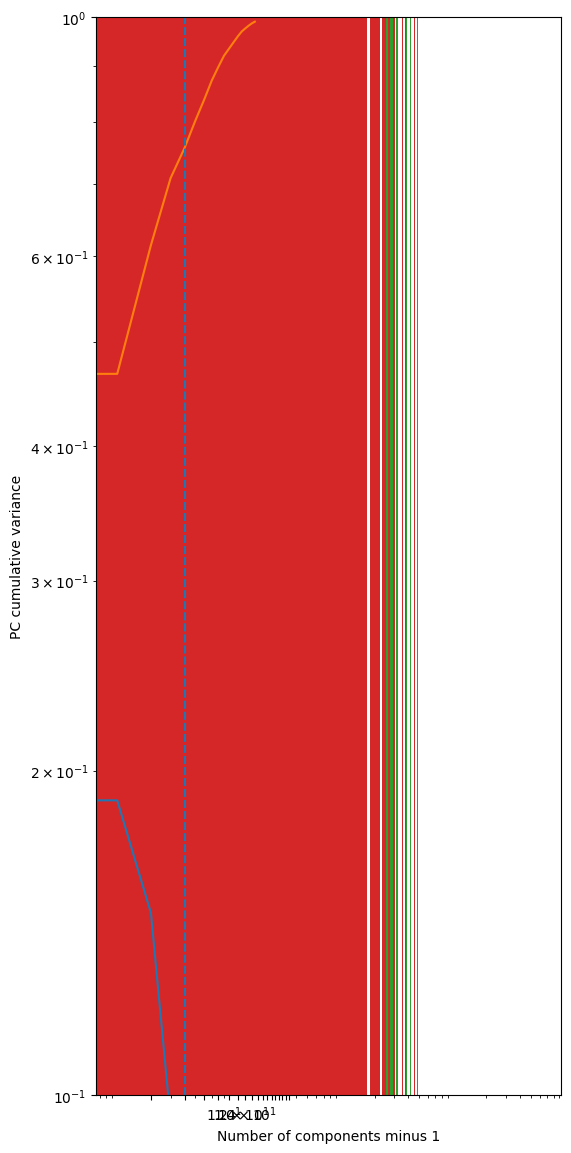

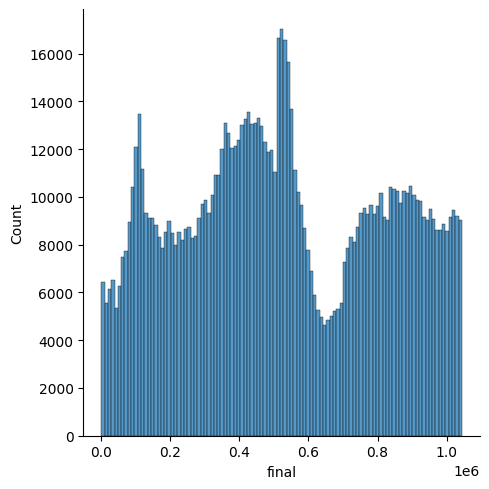

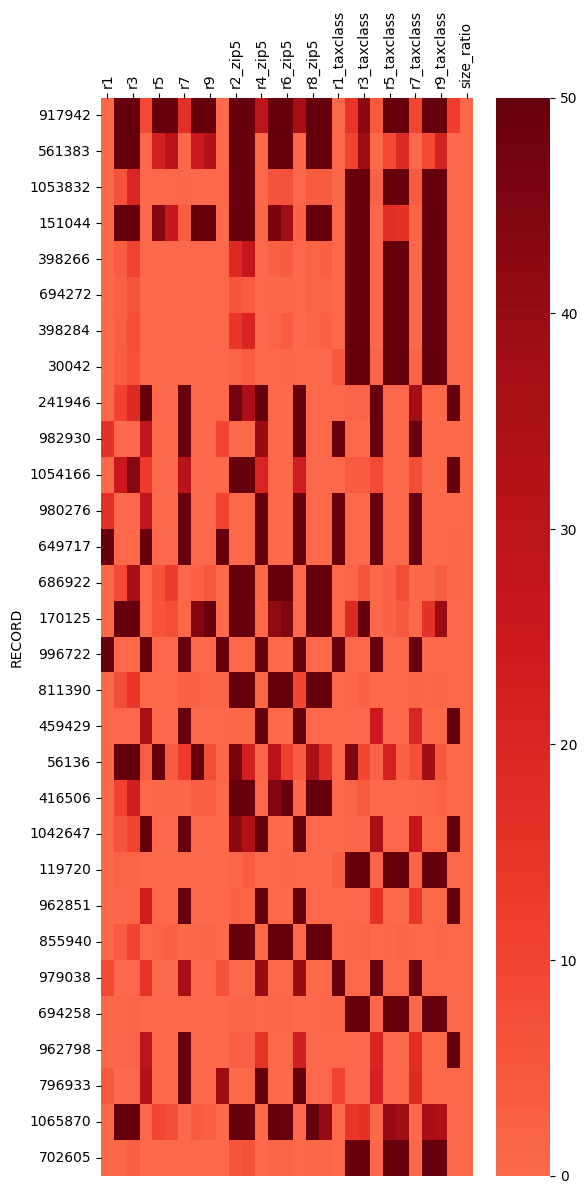

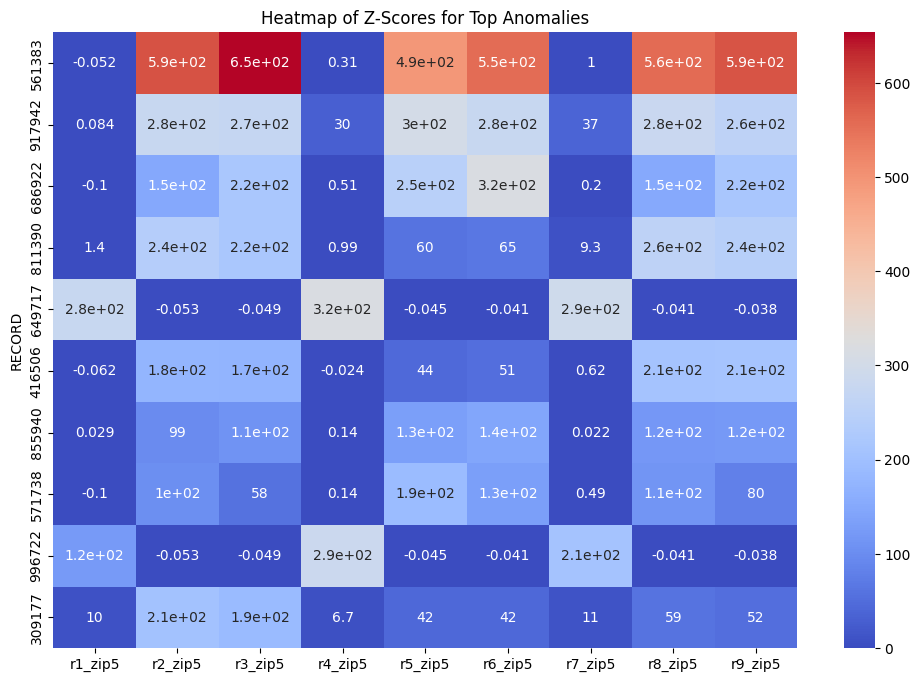

In [337]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top anomalies for visualization
top_anomalies_for_heatmap = top_anomalies.head(10)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_anomalies_for_heatmap[z_score_cols], annot=True, cmap='coolwarm')
plt.title('Heatmap of Z-Scores for Top Anomalies')
plt.show()


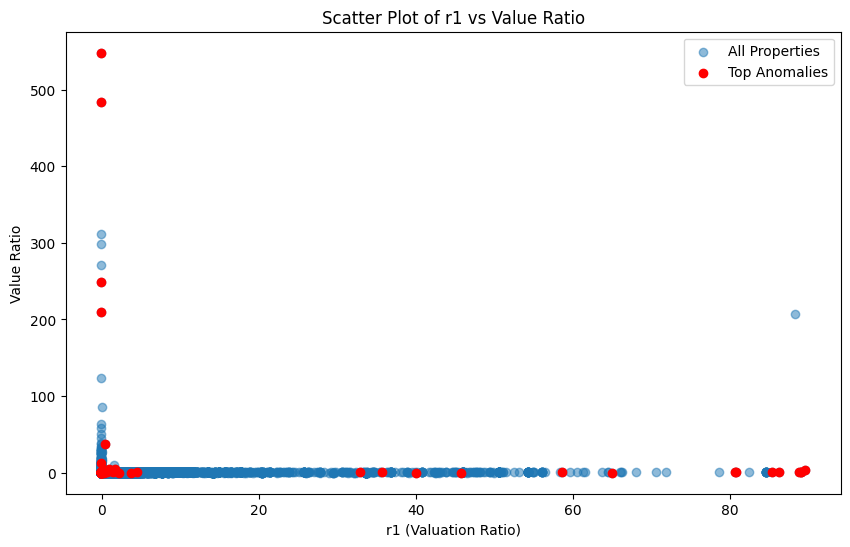

In [339]:
# Scatter plot of 'r1' vs 'value_ratio'
plt.figure(figsize=(10, 6))
plt.scatter(NY_data_scored_zs['r1'], NY_data_scored_zs['value_ratio'], alpha=0.5, label='All Properties')
plt.scatter(top_anomalies['r1'], top_anomalies['value_ratio'], color='red', label='Top Anomalies')
plt.xlabel('r1 (Valuation Ratio)')
plt.ylabel('Value Ratio')
plt.legend()
plt.title('Scatter Plot of r1 vs Value Ratio')
plt.show()


In [341]:
# Select the top 3 anomalies
selected_cases = top_anomalies.head(3)

# Display detailed information for each selected case
for idx, row in selected_cases.iterrows():
    print(f"--- Property Index: {row['BBLE']} ---")
    print(f"Normalized Z-Score: {row['z_score_norm']}")
    print(f"Aggregated Z-Score: {row['z_score']}")
    for col in z_score_cols:
        print(f"{col}: {row[col]}")
    print("\n")


--- Property Index: 3084700055 ---
Normalized Z-Score: 1.0
Aggregated Z-Score: 3435.34748149449
r1_zip5: -0.05171692741517502
r2_zip5: 589.1082250741756
r3_zip5: 653.7942348928051
r4_zip5: 0.31408828079768947
r5_zip5: 493.84263583780904
r6_zip5: 554.800948690554
r7_zip5: 1.029185033383257
r8_zip5: 557.4729417229013
r9_zip5: 585.0369388894792


--- Property Index: 4142600001 ---
Normalized Z-Score: 0.9999990662879531
Aggregated Z-Score: 1732.5636778242606
r1_zip5: 0.08407788883240128
r2_zip5: 278.1431365632762
r3_zip5: 271.91687315268206
r4_zip5: 29.809772035530347
r5_zip5: 301.8447100591522
r6_zip5: 276.5212172063378
r7_zip5: 36.8383593986356
r8_zip5: 279.6603869543142
r9_zip5: 257.7451445654997


--- Property Index: 4037250001 ---
Normalized Z-Score: 0.9999981325759061
Aggregated Z-Score: 1299.4492003245052
r1_zip5: -0.09973344561155949
r2_zip5: 148.34118091245605
r3_zip5: 218.3588161446165
r4_zip5: 0.5143247841760987
r5_zip5: 246.73874366599196
r6_zip5: 317.7708013781135
r7_zip5: 0.1

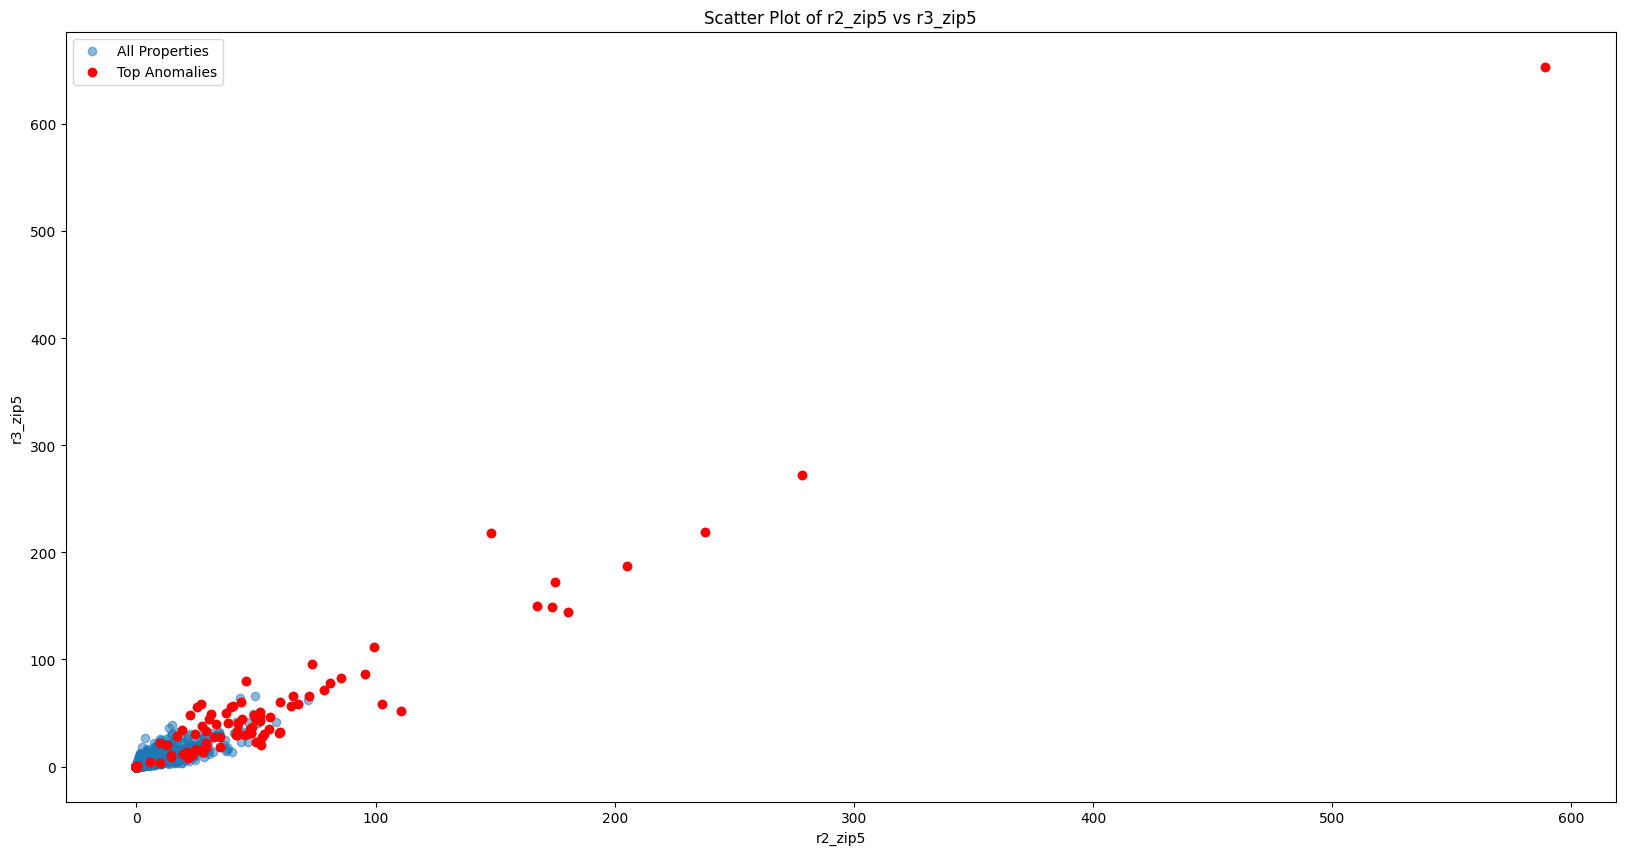

In [343]:
import matplotlib.pyplot as plt

# Scatter plot for r2_zip5 vs. r3_zip5
plt.scatter(NY_data_scored_zs['r2_zip5'], NY_data_scored_zs['r3_zip5'], alpha=0.5, label='All Properties')
plt.scatter(top_anomalies['r2_zip5'], top_anomalies['r3_zip5'], color='red', label='Top Anomalies')
plt.xlabel('r2_zip5')
plt.ylabel('r3_zip5')
plt.legend()
plt.title('Scatter Plot of r2_zip5 vs r3_zip5')
plt.show()


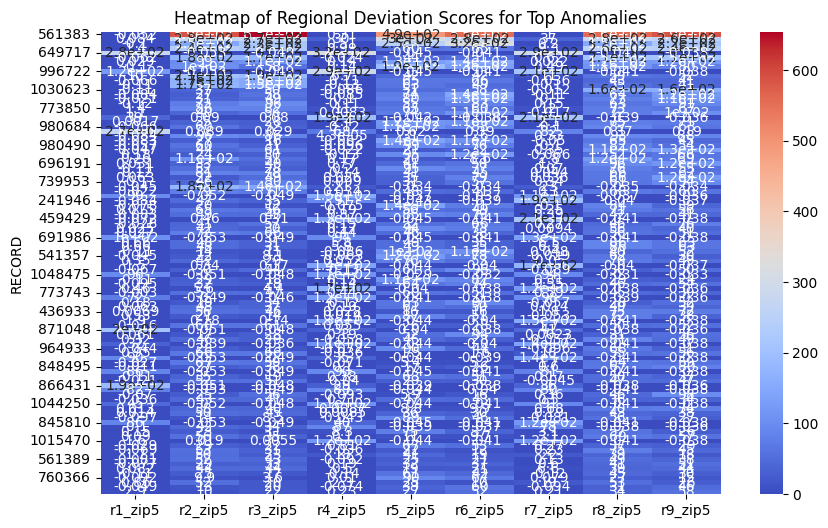

In [345]:
# Heatmap for Top Anomalies
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(top_anomalies[z_score_cols], annot=True, cmap='coolwarm')
plt.title('Heatmap of Regional Deviation Scores for Top Anomalies')
plt.show()


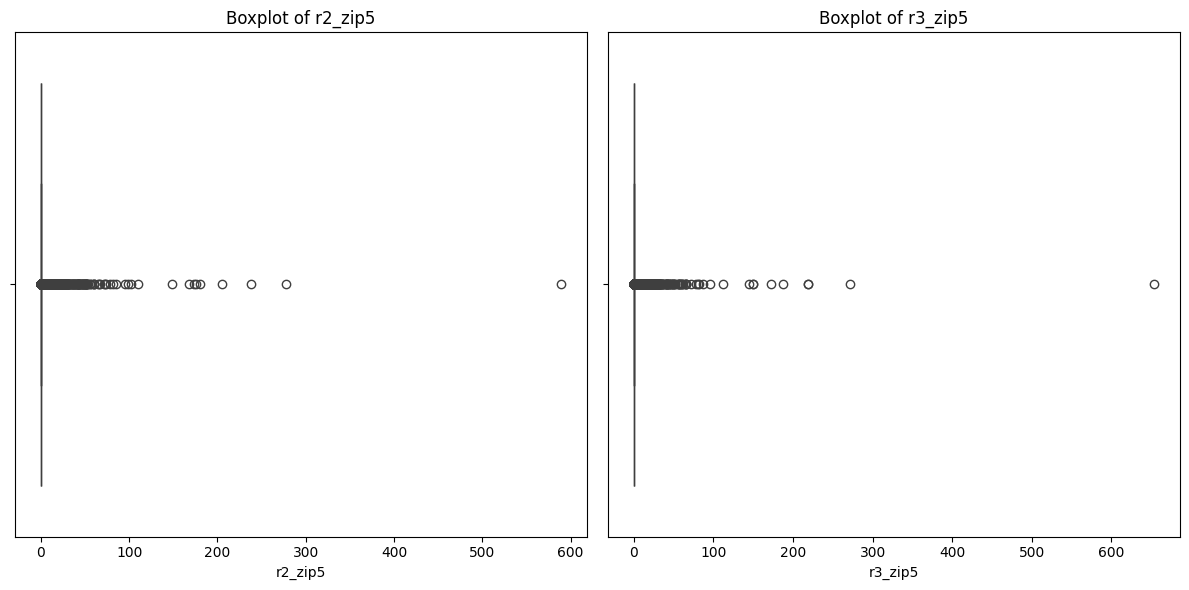

In [347]:
# Boxplot for r2_zip5 and r3_zip5
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for r2_zip5
sns.boxplot(data=NY_data_scored_zs, x=NY_data_scored_zs['r2_zip5'], ax=ax[0])
ax[0].set_title('Boxplot of r2_zip5')

# Boxplot for r3_zip5
sns.boxplot(data=NY_data_scored_zs, x=NY_data_scored_zs['r3_zip5'], ax=ax[1])
ax[1].set_title('Boxplot of r3_zip5')

plt.tight_layout()
plt.show()


In [349]:
# List of properties to analyze
top_properties = ['3084700055', '4142600001', '4037250001']

# Filter the dataset for the top properties
selected_properties = NY_data_scored_zs[NY_data_scored_zs['BBLE'].isin(top_properties)]

# Display relevant details for the properties
print(selected_properties[['BBLE', 'FULLVAL', 'AVLAND', 'AVTOT', 'value_ratio', 'size_ratio'] + z_score_cols])


              BBLE      FULLVAL        AVLAND         AVTOT  value_ratio  \
RECORD                                                                     
561383  3084700055  258000000.0  4.059000e+07  1.161000e+08     0.260499   
686922  4037250001   25100000.0  1.129500e+07  1.129500e+07     0.471818   
917942  4142600001  374019883.0  1.792809e+09  4.668309e+09    12.040708   

        size_ratio   r1_zip5     r2_zip5     r3_zip5    r4_zip5     r5_zip5  \
RECORD                                                                        
561383   -0.029616 -0.051717  589.108225  653.794235   0.314088  493.842636   
686922   -0.029616 -0.099733  148.341181  218.358816   0.514325  246.738744   
917942   -0.029616  0.084078  278.143137  271.916873  29.809772  301.844710   

           r6_zip5    r7_zip5     r8_zip5     r9_zip5  
RECORD                                                 
561383  554.800949   1.029185  557.472942  585.036939  
686922  317.770801   0.198802  152.331896  215.294369  

In [351]:
# Group data by ZIP and calculate regional averages
regional_averages = NY_data_scored_zs.groupby('ZIP')[['FULLVAL', 'value_ratio', 'size_ratio']].mean().reset_index()

# Merge regional averages back into the selected properties
selected_properties = selected_properties.merge(regional_averages, on='ZIP', suffixes=('', '_region'))

# Display the comparison
print(selected_properties[['BBLE', 'FULLVAL', 'FULLVAL_region', 'value_ratio', 'value_ratio_region', 'size_ratio', 'size_ratio_region']])


         BBLE      FULLVAL  FULLVAL_region  value_ratio  value_ratio_region  \
0  3084700055  258000000.0   552168.996400     0.260499           -0.088832   
1  4142600001  374019883.0   495513.139946    12.040708           -0.096341   

   size_ratio  size_ratio_region  
0   -0.029616          -0.001767  
1   -0.029616          -0.010939  


,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio,r1_z,r2_z,r3_z,z_score,z_score_norm
0,3.130243,6.197457e+07,2.492741e+06,16.865039,3.375292e+08,1.344811e+07,25.064485,5.375602e+08,2.157505e+07,0.344811,...,1.288211,7.204130,1.127871,8.056712,1.216887e-08,-0.090143,1.323640,0.198669,1.432167,0.984762
1,4.523796,8.956501e+07,3.602484e+06,24.373205,4.877942e+08,1.943509e+07,36.222944,7.768767e+08,3.118004e+07,0.498317,...,1.861710,10.411337,1.629988,8.056715,1.216887e-08,-0.077343,1.926187,0.300639,2.149483,0.989473
2,8.411301,1.665323e+08,6.698264e+06,25.651791,5.133833e+08,2.045463e+07,67.350964,1.444482e+09,5.797447e+07,0.926544,...,3.461563,19.358271,3.030710,7.135030,1.216887e-08,-0.041635,3.607072,0.585097,4.150535,0.994625
3,1.245200,1.589799e+07,6.394491e+05,4.326310,8.658481e+07,3.449782e+06,6.429659,1.378975e+08,5.534532e+06,0.137165,...,0.330458,1.848037,0.289327,8.056724,1.216887e-08,-0.107457,0.317376,0.028378,0.238297,0.927819
4,1.839398,3.641757e+07,1.464788e+06,9.910288,1.983400e+08,7.902422e+06,14.728427,3.158819e+08,1.267796e+07,0.202618,...,0.756981,4.233301,0.662761,8.056720,1.216887e-08,-0.101999,0.765502,0.104215,0.767718,0.974500


In [355]:
# Extract all BBLE values
bble_values = NY_data_scored_zs['BBLE']
print(bble_values)


RECORD
1          1000010101
2          1000010201
3          1000020001
4          1000020023
5          1000030001
              ...    
1070990    5080500083
1070991    5080500086
1070992    5080500089
1070993    5080500092
1070994    5080500094
Name: BBLE, Length: 1070994, dtype: object


In [369]:
# Ensure the BBLE value to search for is a string
bble_to_search = '3084700055'

# Filter the DataFrame for the specific BBLE
property_row = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_search]

# Display the filtered result
#(property_row)  #uncomment for all rows
# Display key metrics for the property
print(property_row[['BBLE', 'FULLVAL', 'AVLAND', 'AVTOT', 'value_ratio', 'size_ratio', 'r1_zip5', 'r2_zip5', 'r3_zip5']])


              BBLE      FULLVAL      AVLAND        AVTOT  value_ratio  \
RECORD                                                                  
561383  3084700055  258000000.0  40590000.0  116100000.0     0.260499   

        size_ratio   r1_zip5     r2_zip5     r3_zip5  
RECORD                                                
561383   -0.029616 -0.051717  589.108225  653.794235  


In [ ]:
# Display key metrics for the property
print(property_row[['BBLE', 'FULLVAL', 'AVLAND', 'AVTOT', 'value_ratio', 'size_ratio', 'r1_zip5', 'r2_zip5', 'r3_zip5']])


In [371]:
# Compare the property to regional averages
regional_comparison = property_row.merge(regional_averages, on='ZIP', suffixes=('', '_region'))
print(regional_comparison[['BBLE', 'FULLVAL', 'FULLVAL_region', 'value_ratio', 'value_ratio_region']])


         BBLE      FULLVAL  FULLVAL_region  value_ratio  value_ratio_region
0  3084700055  258000000.0     552168.9964     0.260499           -0.088832


In [373]:
# Filter for the property using BBLE
bble_to_search = '3084700055'
property_row = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_search]

# Retrieve the street address and ZIP code
address = property_row[['STADDR', 'ZIP']]

# Display the address
print("Property Address:")
print(address)


Property Address:
               STADDR      ZIP
RECORD                        
561383  5120 AVENUE U  11234.0


In [377]:
# Identify properties with unusual dimensions
dimension_anomalies = NY_data_scored_zs[(NY_data_scored_zs['LTFRONT'] > 1000) | (NY_data_scored_zs['LTDEPTH'] == 0)]

# Sort and display dimension anomalies
print(dimension_anomalies[['BBLE', 'LTFRONT', 'LTDEPTH']].head(5))


              BBLE  LTFRONT  LTDEPTH
RECORD                              
2       1000010201       27        0
9       1000041001        0        0
10      1000041002        0        0
11      1000041003        0        0
12      1000041004        0        0


In [379]:
# Filter out obvious data errors first
filtered_data = NY_data_scored_zs[(NY_data_scored_zs['LTFRONT'] > 0) & (NY_data_scored_zs['LTDEPTH'] > 0)]

# Find extreme value_ratio and size_ratio anomalies
value_ratio_anomalies = filtered_data[filtered_data['value_ratio'] > filtered_data['value_ratio'].quantile(0.99)]
size_ratio_anomalies = filtered_data[filtered_data['size_ratio'].abs() > filtered_data['size_ratio'].quantile(0.99)]

# Combine results for unique properties
non_obvious_anomalies = pd.concat([value_ratio_anomalies, size_ratio_anomalies]).drop_duplicates()

# Display top anomalies
print(non_obvious_anomalies[['BBLE', 'value_ratio', 'size_ratio', 'LTFRONT', 'LTDEPTH']].head(10))


              BBLE  value_ratio  size_ratio  LTFRONT  LTDEPTH
RECORD                                                       
3956    1000170018     0.471818   -0.029616      100      179
4437    1000190024     0.471818   -0.029616       83       46
4628    1000250007     0.471818   -0.029616       63      128
6851    1000520008     0.471818   -0.029616       56      110
6875    1000530002     0.471818   -0.029616       55       87
7052    1000560020     0.471818   -0.029616       22       55
7078    1000630013     0.471818   -0.029616       46      100
7504    1000720002     0.471818   -0.029616      115       48
8296    1000790019     0.471818   -0.029616       48      160
8430    1000900017     0.471818   -0.029616       25      102


In [385]:
# Check for missing or zero values in LTFRONT and LTDEPTH
print(filtered_data[['LTFRONT', 'LTDEPTH']].describe())
print(filtered_data[['LTFRONT', 'LTDEPTH']].isnull().sum())
print(filtered_data[(filtered_data['LTFRONT'] <= 0) | (filtered_data['LTDEPTH'] <= 0)])


             LTFRONT        LTDEPTH
count  900649.000000  900649.000000
mean       43.456022     105.645522
std        78.246925      71.866661
min         1.000000       1.000000
25%        20.000000      97.000000
50%        25.000000     100.000000
75%        40.000000     100.000000
max      9999.000000    9999.000000
LTFRONT    0
LTDEPTH    0
dtype: int64
Empty DataFrame
Columns: [BBLE, BORO, BLOCK, LOT, EASEMENT, OWNER, BLDGCL, TAXCLASS, LTFRONT, LTDEPTH, EXT, STORIES, FULLVAL, AVLAND, AVTOT, EXLAND, EXTOT, EXCD1, STADDR, ZIP, EXMPTCL, BLDFRONT, BLDDEPTH, AVLAND2, AVTOT2, EXLAND2, EXTOT2, EXCD2, PERIOD, YEAR, VALTYPE, score1 rank, score2 rank, final, r1, r2, r3, r4, r5, r6, r7, r8, r9, r1_zip5, r2_zip5, r3_zip5, r4_zip5, r5_zip5, r6_zip5, r7_zip5, r8_zip5, r9_zip5, r1_taxclass, r2_taxclass, r3_taxclass, r4_taxclass, r5_taxclass, r6_taxclass, r7_taxclass, r8_taxclass, r9_taxclass, value_ratio, size_ratio, z_score, z_score_norm, lot_size]
Index: []

[0 rows x 66 columns]


In [387]:
# Create a copy to avoid warnings
filtered_data = NY_data_scored_zs[(NY_data_scored_zs['LTFRONT'] > 0) & (NY_data_scored_zs['LTDEPTH'] > 0)].copy()

# Calculate lot_size
filtered_data['lot_size'] = filtered_data['LTFRONT'] * filtered_data['LTDEPTH']

# Identify properties where lot_size is unusually small given high FULLVAL
small_lot_anomalies = filtered_data[(filtered_data['FULLVAL'] > 5e6) & (filtered_data['lot_size'] < 2000)]

# Sort and display
print(small_lot_anomalies[['BBLE', 'FULLVAL', 'lot_size', 'LTFRONT', 'LTDEPTH']].sort_values(by='lot_size').head(10))


              BBLE    FULLVAL  lot_size  LTFRONT  LTDEPTH
RECORD                                                   
105233  1014380044  8630000.0       500      100        5
101478  1014110133  8570000.0       550       22       25
33419   1006440056  5766000.0       594       11       54
31286   1006190009  5450000.0       612       34       18
30901   1006140050  5630000.0       720       20       36
30543   1006110003  5710000.0       800       20       40
8077    1000780040  6140000.0       816       16       51
97051   1013720033  5810000.0       816       16       51
97052   1013720034  5950000.0       816       16       51
97058   1013720042  6040000.0       816       16       51


In [389]:
# Add LTFRONT-to-LTDEPTH ratio
filtered_data['front_depth_ratio'] = filtered_data['LTFRONT'] / filtered_data['LTDEPTH']

# Find extreme ratios (narrow or extremely wide lots)
extreme_ratios = filtered_data[(filtered_data['front_depth_ratio'] > 10) | (filtered_data['front_depth_ratio'] < 0.1)]

# Display results
print(extreme_ratios[['BBLE', 'LTFRONT', 'LTDEPTH', 'front_depth_ratio']].head(10))


               BBLE  LTFRONT  LTDEPTH  front_depth_ratio
RECORD                                                  
4431     1000190008        1       70           0.014286
6090     1000340037      360       33          10.909091
6420    1000440008E      151       15          10.066667
8923     1001060022       11      261           0.042146
11179    1001610003       32      359           0.089136
12342    1001840002       70      859           0.081490
12345    1001840010       75      999           0.075075
12912    1001931001        5      127           0.039370
13019    1001937501        5      127           0.039370
15609    1002430001     1102       68          16.205882


In [391]:
# Combine the two anomaly types
combined_anomalies = pd.concat([small_lot_anomalies, extreme_ratios]).drop_duplicates()

# Display combined anomalies
print(combined_anomalies[['BBLE', 'FULLVAL', 'lot_size', 'LTFRONT', 'LTDEPTH', 'front_depth_ratio']])


               BBLE    FULLVAL  lot_size  LTFRONT  LTDEPTH  front_depth_ratio
RECORD                                                                       
4434     1000190018  6520000.0      1843       19       97                NaN
5614     1000290026  8000000.0      1752       24       73                NaN
5619     1000290046  6550000.0      1264       16       79                NaN
5677     1000300032  6910000.0      1596       28       57                NaN
5678     1000300033  5990000.0      1488       24       62                NaN
...             ...        ...       ...      ...      ...                ...
1070668  5080410104     3450.0       110        1      110           0.009091
1070725  5080430024   660000.0      2394       14      171           0.081871
1070891  5080470079   346950.0      2190       10      219           0.045662
1070913  5080480037     1000.0      3975       15      265           0.056604
1070980  5080500055     3720.0       238        2      119      

In [412]:
# Filter the DataFrame for the specific BBLE value
bble_to_filter = '4142600001'
filtered_row = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]

# Display the filtered row
(filtered_row)


,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio,z_score,z_score_norm
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.555461,384.936473,632.107821,9.479407,351.349667,659.897578,12.040708,-0.029616,1732.563678,0.999999


In [400]:
# Check the STORIES value for BBLE = 4142600001
bble_to_filter = '4142600001'
filtered_row = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]
print(filtered_row[['BBLE', 'STORIES']])


              BBLE  STORIES
RECORD                     
917942  4142600001      3.0


In [402]:
# Define the BBLE value for the property
bble_to_filter = '4142600001'

# Filter the dataset for the specific BBLE
filtered_property = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]

# Display the address columns (STADDR and ZIP)
if not filtered_property.empty:
    print("Property Address:")
    print(filtered_property[['BBLE', 'STADDR', 'ZIP']])
else:
    print(f"No property found for BBLE {bble_to_filter}")


Property Address:
              BBLE                       STADDR      ZIP
RECORD                                                  
917942  4142600001  154-68 BROOKVILLE BOULEVARD  11422.0


In [404]:
# Define the BBLE value for the property
bble_to_filter = '5080410104'

# Filter the dataset for the specific BBLE
filtered_property = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]

# Display the address columns (STADDR and ZIP)
if not filtered_property.empty:
    print("Property Address:")
    print(filtered_property[['BBLE', 'STADDR', 'ZIP']])
else:
    print(f"No property found for BBLE {bble_to_filter}")


Property Address:
               BBLE          STADDR  ZIP
RECORD                                  
1070668  5080410104  BREHAUT AVENUE  NaN


In [406]:
# Define the BBLE value for the property
bble_to_filter = '5080410104'

# Filter the dataset for the specific BBLE
filtered_property = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]

# Retrieve and display the FULLVAL
if not filtered_property.empty:
    fullval = filtered_property['FULLVAL'].values[0]
    print(f"FULLVAL for BBLE {bble_to_filter}: ${fullval:,}")
else:
    print(f"No property found for BBLE {bble_to_filter}")


FULLVAL for BBLE 5080410104: $3,450.0


In [410]:
# Assuming 'df' is your DataFrame and already loaded

property_id = "4142600001"  # Property ID to search for

# Filter the DataFrame for the specific property ID
address = df.loc[df['property_id'] == property_id, 'address'].values

# Print the result
if address:
    print(f"Address for property ID {property_id}: {address[0]}")
else:
    print(f"Property ID {property_id} not found.")


NameError: name 'df' is not defined

In [416]:
# Define the BBLE value for the property
bble_to_filter = '4142600001'

# Verify that the column FULLVAL exists in the DataFrame
if 'FULLVAL' in NY_data_scored_zs.columns:
    # Filter the dataset for the specific BBLE
    filtered_property = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]
    
    # Retrieve and display the FULLVAL
    if not filtered_property.empty:
        fullval = filtered_property['FULLVAL'].values[0]
        print(f"FULLVAL for BBLE {bble_to_filter}: ${fullval:,}")
    else:
        print(f"No property found for BBLE {bble_to_filter}")
else:
    print("FULLVAL column not found in the dataset. Please check the DataFrame structure.")
    
# Optional: Verify the structure of the DataFrame
print("Columns in the DataFrame:")
print(NY_data_scored_zs.columns)


FULLVAL for BBLE 4142600001: $374,019,883.0
Columns in the DataFrame:
Index(['BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'score1 rank', 'score2 rank',
       'final', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass',
       'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass',
       'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'value_ratio',
       'size_ratio', 'z_score', 'z_score_norm'],
      dtype='object')


In [418]:
# Define the BBLE value for the property
bble_to_filter = '4037250001'

# Filter the dataset for the specific BBLE
filtered_property = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]

# Retrieve and display the FULLVAL and Address (STADDR and ZIP)
if not filtered_property.empty:
    fullval = filtered_property['FULLVAL'].values[0]
    address = filtered_property['STADDR'].values[0] if 'STADDR' in filtered_property.columns else 'Address not available'
    zip_code = filtered_property['ZIP'].values[0] if 'ZIP' in filtered_property.columns else 'ZIP not available'
    
    print(f"FULLVAL for BBLE {bble_to_filter}: ${fullval:,}")
    print(f"Address: {address}, ZIP: {zip_code}")
else:
    print(f"No property found for BBLE {bble_to_filter}")


FULLVAL for BBLE 4037250001: $25,100,000.0
Address: CYPRESS AVENUE, ZIP: nan


In [420]:
# Define the BBLE value for the property
bble_to_filter = '4037250001'

# Filter the dataset for the specific BBLE
filtered_property = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]

# Retrieve and calculate the lot size
if not filtered_property.empty:
    ltfront = filtered_property['LTFRONT'].values[0] if 'LTFRONT' in filtered_property.columns else None
    ltdepth = filtered_property['LTDEPTH'].values[0] if 'LTDEPTH' in filtered_property.columns else None
    
    # Calculate lot size if both LTFRONT and LTDEPTH are available
    if ltfront and ltdepth:
        lot_size = ltfront * ltdepth
        print(f"Lot Size for BBLE {bble_to_filter}: {lot_size} sq. ft.")
    else:
        print("LTFRONT or LTDEPTH data is missing for this property.")
else:
    print(f"No property found for BBLE {bble_to_filter}")


Lot Size for BBLE 4037250001: 183977 sq. ft.


In [422]:
zip_code = filtered_property['ZIP'].values[0]
regional_properties = NY_data_scored_zs[NY_data_scored_zs['ZIP'] == zip_code]
regional_avg_val_per_sqft = (regional_properties['FULLVAL'] / 
                             (regional_properties['LTFRONT'] * regional_properties['LTDEPTH'])).mean()
print(f"Regional Average Valuation per sq. ft.: ${regional_avg_val_per_sqft:,.2f}")


Regional Average Valuation per sq. ft.: $nan


In [424]:
# Filter out invalid rows
valid_regional_properties = regional_properties[
    (regional_properties['FULLVAL'] > 0) &
    (regional_properties['LTFRONT'] > 0) &
    (regional_properties['LTDEPTH'] > 0)
]

# Calculate the regional average valuation per square foot
if not valid_regional_properties.empty:
    valid_regional_properties['lot_size'] = valid_regional_properties['LTFRONT'] * valid_regional_properties['LTDEPTH']
    regional_avg_val_per_sqft = (valid_regional_properties['FULLVAL'] / valid_regional_properties['lot_size']).mean()
    print(f"Regional Average Valuation per sq. ft.: ${regional_avg_val_per_sqft:,.2f}")
else:
    print("No valid regional properties found for comparison.")


No valid regional properties found for comparison.


In [426]:
print(f"Number of valid regional properties: {len(valid_regional_properties)}")


Number of valid regional properties: 0


In [430]:
# Filter for valid properties with meaningful FULLVAL, LTFRONT, and LTDEPTH
valid_properties = NY_data_scored_zs[
    (NY_data_scored_zs['FULLVAL'] > 20000) &
    (NY_data_scored_zs['LTFRONT'] > 0) &
    (NY_data_scored_zs['LTDEPTH'] > 0)
].copy()  # Use .copy() to create a new DataFrame and avoid the warning

# Calculate lot size if not already calculated
valid_properties.loc[:, 'lot_size'] = valid_properties['LTFRONT'] * valid_properties['LTDEPTH']

# Calculate valuation per sq. ft.
valid_properties.loc[:, 'val_per_sqft'] = valid_properties['FULLVAL'] / valid_properties['lot_size']

# Drop rows with missing or zero lot size
valid_properties = valid_properties[valid_properties['lot_size'] > 0].copy()


In [432]:
# Sort by highest valuation per sq. ft.
high_valuation_anomalies = valid_properties.sort_values(by='val_per_sqft', ascending=False).head(3)

# Sort by lowest valuation per sq. ft.
low_valuation_anomalies = valid_properties.sort_values(by='val_per_sqft', ascending=True).head(3)

# Sort by extreme value_ratio
extreme_ratio_anomalies = valid_properties.sort_values(by='value_ratio', ascending=False).head(3)


In [434]:
# Combine anomalies and drop duplicates
anomaly_candidates = pd.concat([high_valuation_anomalies, low_valuation_anomalies, extreme_ratio_anomalies])
unique_anomalies = anomaly_candidates.drop_duplicates(subset='BBLE')

# Select 3 unique properties for deeper analysis
final_anomalies = unique_anomalies.head(3)
print("Selected Anomalies:")
print(final_anomalies[['BBLE', 'FULLVAL', 'val_per_sqft', 'value_ratio', 'lot_size', 'LTFRONT', 'LTDEPTH']])


Selected Anomalies:
               BBLE       FULLVAL   val_per_sqft  value_ratio  lot_size  \
RECORD                                                                    
1067360  5078530085  8.360000e+05  836000.000000    -0.110204         1   
565392   3085900700  4.326304e+09  342379.210193          NaN     12636   
770594   4076211145  2.519890e+05  251989.000000    -0.073075         1   

         LTFRONT  LTDEPTH  
RECORD                     
1067360        1        1  
565392       117      108  
770594         1        1  


In [438]:
# Define the BBLE value
bble_to_filter = '3085900700'

# Filter the dataset for the specific BBLE
filtered_property = NY_data_scored_zs[NY_data_scored_zs['BBLE'] == bble_to_filter]

# Retrieve and display the address, ZIP, and FULLVAL
if not filtered_property.empty:
    address = filtered_property['STADDR'].values[0] if 'STADDR' in filtered_property.columns else 'Address not available'
    zip_code = filtered_property['ZIP'].values[0] if 'ZIP' in filtered_property.columns else 'ZIP not available'
    fullval = filtered_property['FULLVAL'].values[0]
    print(f"BBLE: {bble_to_filter}")
    print(f"FULLVAL: ${fullval:,}")
    print(f"Address: {address}")
    print(f"ZIP Code: {zip_code}")
else:
    print(f"No property found for BBLE {bble_to_filter}")


BBLE: 3085900700
FULLVAL: $4,326,303,700.0
Address: FLATBUSH AVENUE
ZIP Code: nan


In [440]:
# Step 1: Filter valid properties (exclude invalid entries)
valid_properties = NY_data_scored_zs[
    (NY_data_scored_zs['FULLVAL'] > 20000) &  # Exclude very low FULLVAL
    (NY_data_scored_zs['LTFRONT'] > 0) & 
    (NY_data_scored_zs['LTDEPTH'] > 0)
].copy()

# Step 2: Add necessary metrics if not already present
valid_properties.loc[:, 'lot_size'] = valid_properties['LTFRONT'] * valid_properties['LTDEPTH']
valid_properties.loc[:, 'val_per_sqft'] = valid_properties['FULLVAL'] / valid_properties['lot_size']

# Step 3: Exclude high-priced areas (e.g., Flatbush Avenue)
excluded_regions = ['Flatbush Avenue']
filtered_properties = valid_properties[~valid_properties['STADDR'].isin(excluded_regions)].copy()

# Step 4: Identify anomalies
# a) High valuation per square foot
high_val_anomalies = filtered_properties.sort_values(by='val_per_sqft', ascending=False).head(5)

# b) Low valuation per square foot
low_val_anomalies = filtered_properties.sort_values(by='val_per_sqft', ascending=True).head(5)

# c) Large lot size with low FULLVAL
large_lot_low_value = filtered_properties.sort_values(by=['lot_size', 'FULLVAL'], ascending=[False, True]).head(5)

# Step 5: Combine and deduplicate results
anomalies = pd.concat([high_val_anomalies, low_val_anomalies, large_lot_low_value])
anomalies = anomalies.drop_duplicates(subset='BBLE').head(3)  # Keep 3 unique examples

# Display the anomalies
print("Selected New Anomalies:")
print(anomalies[['BBLE', 'FULLVAL', 'val_per_sqft', 'lot_size', 'LTFRONT', 'LTDEPTH', 'STADDR', 'ZIP']])


Selected New Anomalies:
               BBLE       FULLVAL   val_per_sqft  lot_size  LTFRONT  LTDEPTH  \
RECORD                                                                         
1067360  5078530085  8.360000e+05  836000.000000         1        1        1   
565392   3085900700  4.326304e+09  342379.210193     12636      117      108   
770594   4076211145  2.519890e+05  251989.000000         1        1        1   

                   STADDR      ZIP  
RECORD                              
1067360    20 EMILY COURT  10307.0  
565392    FLATBUSH AVENUE      NaN  
770594   220-71 67 AVENUE  11364.0  


In [442]:
# Step 1: Filter valid properties (Exclude invalid entries and lot sizes <= 20)
valid_properties = NY_data_scored_zs[
    (NY_data_scored_zs['FULLVAL'] > 20000) &  # Exclude very low FULLVAL
    (NY_data_scored_zs['LTFRONT'] > 0) & 
    (NY_data_scored_zs['LTDEPTH'] > 0)
].copy()

# Add Lot Size and Valuation per Square Foot Metrics
valid_properties['lot_size'] = valid_properties['LTFRONT'] * valid_properties['LTDEPTH']
valid_properties['val_per_sqft'] = valid_properties['FULLVAL'] / valid_properties['lot_size']

# Filter properties where lot size > 20
filtered_properties = valid_properties[valid_properties['lot_size'] > 20].copy()

# Step 2: Identify anomalies
# a) High valuation per square foot
high_val_anomalies = filtered_properties.sort_values(by='val_per_sqft', ascending=False).head(5)

# b) Low valuation per square foot
low_val_anomalies = filtered_properties.sort_values(by='val_per_sqft', ascending=True).head(5)

# c) Large lot size with low FULLVAL
large_lot_low_value = filtered_properties.sort_values(by=['lot_size', 'FULLVAL'], ascending=[False, True]).head(5)

# Combine and deduplicate results
anomalies = pd.concat([high_val_anomalies, low_val_anomalies, large_lot_low_value])
anomalies = anomalies.drop_duplicates(subset='BBLE').head(3)  # Keep 3 unique examples

# Display the anomalies
print("Filtered Anomalies with Lot Size > 20:")
print(anomalies[['BBLE', 'FULLVAL', 'val_per_sqft', 'lot_size', 'LTFRONT', 'LTDEPTH', 'STADDR', 'ZIP']])


Filtered Anomalies with Lot Size > 20:
              BBLE       FULLVAL   val_per_sqft  lot_size  LTFRONT  LTDEPTH  \
RECORD                                                                        
565392  3085900700  4.326304e+09  342379.210193     12636      117      108   
116647  1015410021  1.610000e+08   85866.666667      1875       25       75   
556609  3083120001  1.360000e+08   77714.285714      1750       35       50   

                     STADDR      ZIP  
RECORD                                
565392      FLATBUSH AVENUE      NaN  
116647        1849 2 AVENUE  10128.0  
556609  9006 SEAVIEW AVENUE  11236.0  
